<a href="https://colab.research.google.com/github/maishatabassum2/Titanic-Dataset/blob/main/gradient_boosting%2B6_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/competitions/titanic/submissions")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aula2333
Your Kaggle Key: ··········


100%|██████████| 34.1k/34.1k [00:00<00:00, 92.1MB/s]


Extracting archive ./titanic/titanic.zip to ./titanic


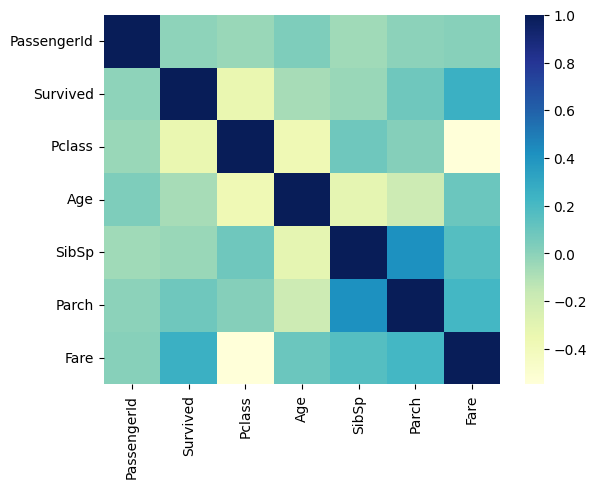

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Train Accuracy: 0.8778089887640449
Test Accuracy: 0.8100558659217877
Saved predictions.csv


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [6]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier



import pandas as pd
titanicdata = pd.read_csv("/content/titanic/train.csv")

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


numeric_data = titanicdata.select_dtypes(include=np.number)

sns.heatmap(numeric_data.corr(), cmap="YlGnBu")
plt.show()



from sklearn.model_selection import train_test_split

X = titanicdata.drop("Survived", axis=1)
y = titanicdata["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing to fit

    def transform(self, X):
        df = X.copy()


        df['Title'] = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())


        normalized_titles = {
            "Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir":        "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess": "Royalty",
            "Countess":   "Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Miss",
            "Mr":         "Mr",
            "Mrs":        "Mrs",
            "Miss":       "Miss",
            "Master":     "Master",
            "Lady":       "Royalty"
        }

        df['Title'] = df['Title'].map(normalized_titles)

        df['Title'] = df['Title'].fillna('Unknown')

        return df


class FamilySizeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
        return df

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_age = X['Age'].median()
        return self

    def transform(self, X):
        df = X.copy()
        df['Age'] = df['Age'].fillna(self.median_age)
        return df

class FareImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_fare = X['Fare'].median()
        return self

    def transform(self, X):
        df = X.copy()
        df['Fare'] = df['Fare'].fillna(self.median_fare)
        return df

class IsAloneAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['IsAlone'] = (df['Family_Size'] == 1).astype(int)
        return df


class DeckExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        def get_deck(cabin):
            if pd.isna(cabin):
                return 'Unknown'
            return cabin[0]
        df['Deck'] = df['Cabin'].apply(get_deck)
        return df

train_set, test_set = train_test_split(
    titanicdata, test_size=0.2, random_state=42, stratify=titanicdata['Survived']
)

X_train = train_set.drop('Survived', axis=1)
y_train = train_set['Survived']
X_test = test_set.drop('Survived', axis=1)
y_test = test_set['Survived']

feature_engineering = Pipeline([
    ('title', TitleExtractor()),
    ('deck', DeckExtractor()),
    ('family', FamilySizeAdder()),
    ('age', AgeImputer()),
    ('fare', FareImputer()),
    ('is_alone', IsAloneAdder())
])


numeric_features = ['Age', 'Fare', 'Pclass', 'Family_Size']
categorical_features = ['Sex', 'Title', 'Deck']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model_pipeline = Pipeline([
    ('feature_engineering', feature_engineering),
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        random_state=42,
        subsample=0.8,
        max_features='sqrt',
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-4) )
])


param_grid = {
    "classifier__n_estimators": [100, 200],     # fewer trees is safer
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3],               # shallow trees reduce overfitting
    "classifier__min_samples_split": [3, 5],    # avoid splits on tiny samples
    "classifier__min_samples_leaf": [2, 4]      # minimum leaf size larger
}


from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)

grid_search.fit(X_train, y_train)

final_clf = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Train Accuracy:", final_clf.score(X_train, y_train))
print("Test Accuracy:", final_clf.score(X_test, y_test))

titanic_test = pd.read_csv("/content/titanic/test.csv")
predictions = final_clf.predict(titanic_test)

submission = pd.DataFrame({
    "PassengerId": titanic_test['PassengerId'],
    "Survived": predictions
})
submission.to_csv("predictionsnew1.csv", index=False)
print("Saved predictions.csv")



